<h1>Model: Male Anger vs Fear vs. Neutral</h1>

In [11]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [12]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU, SpatialDropout2D

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict
from PIL import Image

<h2>Data Loading and Preparation</h2>

In [13]:
def getEmotionCode(x):
    part = x.split('_')
    if part[3] == 'FEA':
        return 1
    elif part[3] =='ANG':
        return 2
    else:
        return 0

def getEmotion(x):
    if x == 1:
        return 'FEA'
    elif x ==2:
        return 'ANG'
    else:
        return 'NEU'

In [14]:
X_all = []
Y_all = []

image_folder_path = 'cremad/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    split_file_name = file_name.split('_')
    if split_file_name[0] == 'M' and (split_file_name[3] in ['FEA','ANG','NEU']):
        spectrogram = Image.open(image_folder_path + '/' + file_name)
        spectrogram = spectrogram.convert('L')
        spectrogram = spectrogram.resize((167, 109))
        spectrogram = np.array(spectrogram)
        spectrogram = np.expand_dims(spectrogram, axis=2)
        X_all.append(spectrogram)
        Y_all.append(getEmotionCode(file_name))
    
#print(X_all)
#print(Y_all)


In [15]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=3)

#print(X_all)
#print(Y_all)

(1917, 109, 167, 1)
(1917,)


In [16]:
# train /test= 80/20% split
# stratified
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 123, stratify=Y_all)



<h2>Model Building</h2>

In [17]:
 def build_current_model():
    inp = Input(shape=(109, 167,1))
    
    c1 = Convolution2D(filters=128,kernel_size=(5,5),strides=(2,2),padding='same')(inp)
    bt = BatchNormalization()(c1)
    bt = Activation('relu')(bt)
    mpool = SpatialDropout2D(0.2)(bt)
    mpool = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(mpool)
   

    
    c2 = Convolution2D(filters=256,kernel_size=(4,4),strides=(2,2),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = SpatialDropout2D(0.3)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(mpool)
    
    
    c2 = Convolution2D(filters=512,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = SpatialDropout2D(0.3)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(mpool)
    
    
    c3 = Convolution2D(filters=512,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c3)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = SpatialDropout2D(0.4)(mpool)
    
    f = Flatten()(mpool)
    
    x_dense = Dense(2048)(f)
    bt = BatchNormalization()(x_dense)
    bt = Activation('tanh')(bt)
    bt = Dropout(0.4)(bt)

    
    x_dense = Dense(2048)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('tanh')(bt)
    bt = Dropout(0.3)(bt)
    
    x_dense = Dense(512)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('tanh')(bt)
    bt = Dropout(0.2)(bt)

    x_out = Dense(3, name='output', activation='softmax')(bt)
    
    model = Model(inputs=inp, outputs=x_out)
    model.compile(optimizer=Adam(lr=0.0005), 
                  loss='categorical_crossentropy', 
                  metrics = ['accuracy'])
    return model


In [18]:
model = build_current_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 109, 167, 1)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 55, 84, 128)       3328      
_________________________________________________________________
batch_normalization_7 (Batch (None, 55, 84, 128)       512       
_________________________________________________________________
activation_7 (Activation)    (None, 55, 84, 128)       0         
_________________________________________________________________
spatial_dropout2d_4 (Spatial (None, 55, 84, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 42, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 21, 256)       5245

In [19]:
#tf.keras.utils.plot_model(model, "Model-Ref7Var.png", show_shapes=True)

In [20]:
from tensorflow.keras.callbacks import TensorBoard
import time

name = "MaleFeaAngNeu-{}".format(int(time.time()))
print(name)
tensorboard = TensorBoard(log_dir="logs/{}".format(name))

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 patience=100,
                                                 verbose=1, 
                                                 mode='min',
                                                 restore_best_weights=True)

my_callbacks = [early_stop]

history = model.fit(X_train, Y_train, 
              epochs = 500, 
              validation_split=0.1, 
              verbose=1, 
              batch_size = 8,
              callbacks=my_callbacks)

history_info = history.history

MaleFeaAngNeu-1591043534
Train on 1379 samples, validate on 154 samples
Epoch 1/500
1379/1379 [==============================] - 4s 3ms/sample - loss: 1.5156 - acc: 0.4975 - val_loss: 1.6762 - val_acc: 0.2987
Epoch 2/500
1379/1379 [==============================] - 2s 2ms/sample - loss: 0.9733 - acc: 0.5497 - val_loss: 1.9370 - val_acc: 0.2987
Epoch 3/500
1379/1379 [==============================] - 3s 2ms/sample - loss: 0.9554 - acc: 0.5577 - val_loss: 1.6416 - val_acc: 0.3052
Epoch 4/500
1379/1379 [==============================] - 3s 2ms/sample - loss: 0.9555 - acc: 0.5482 - val_loss: 0.8508 - val_acc: 0.5974
Epoch 5/500
1379/1379 [==============================] - 3s 2ms/sample - loss: 0.8916 - acc: 0.5852 - val_loss: 0.7552 - val_acc: 0.6623
Epoch 6/500
1379/1379 [==============================] - 3s 2ms/sample - loss: 0.8959 - acc: 0.5874 - val_loss: 0.7481 - val_acc: 0.7078
Epoch 7/500
1379/1379 [==============================] - 3s 2ms/sample - loss: 0.8746 - acc: 0.6062 - val_

Epoch 60/500
1379/1379 [==============================] - 3s 2ms/sample - loss: 0.5192 - acc: 0.7941 - val_loss: 0.5677 - val_acc: 0.7727
Epoch 61/500
1379/1379 [==============================] - 2s 2ms/sample - loss: 0.5255 - acc: 0.7926 - val_loss: 0.5335 - val_acc: 0.7857
Epoch 62/500
1379/1379 [==============================] - 3s 2ms/sample - loss: 0.5156 - acc: 0.7904 - val_loss: 0.5237 - val_acc: 0.7727
Epoch 63/500
1379/1379 [==============================] - 3s 2ms/sample - loss: 0.4826 - acc: 0.8107 - val_loss: 0.5720 - val_acc: 0.7597
Epoch 64/500
1379/1379 [==============================] - 3s 2ms/sample - loss: 0.4950 - acc: 0.7970 - val_loss: 0.4926 - val_acc: 0.8182
Epoch 65/500
1379/1379 [==============================] - 3s 2ms/sample - loss: 0.5066 - acc: 0.7854 - val_loss: 0.5381 - val_acc: 0.7468
Epoch 66/500
1379/1379 [==============================] - 3s 2ms/sample - loss: 0.5015 - acc: 0.8042 - val_loss: 0.5211 - val_acc: 0.8117
Epoch 67/500
1379/1379 [==========

1379/1379 [==============================] - 3s 2ms/sample - loss: 0.2262 - acc: 0.9210 - val_loss: 0.7490 - val_acc: 0.7403
Epoch 120/500
1379/1379 [==============================] - 3s 2ms/sample - loss: 0.2410 - acc: 0.9065 - val_loss: 0.6769 - val_acc: 0.7662
Epoch 121/500
1379/1379 [==============================] - 3s 2ms/sample - loss: 0.2111 - acc: 0.9181 - val_loss: 0.7396 - val_acc: 0.7792
Epoch 122/500
1379/1379 [==============================] - 3s 2ms/sample - loss: 0.1557 - acc: 0.9391 - val_loss: 0.7654 - val_acc: 0.7532
Epoch 123/500
1379/1379 [==============================] - 3s 2ms/sample - loss: 0.2087 - acc: 0.9362 - val_loss: 0.7660 - val_acc: 0.7403
Epoch 124/500
1379/1379 [==============================] - 3s 2ms/sample - loss: 0.2149 - acc: 0.9268 - val_loss: 0.8523 - val_acc: 0.7403
Epoch 125/500
1379/1379 [==============================] - 3s 2ms/sample - loss: 0.1779 - acc: 0.9456 - val_loss: 0.6351 - val_acc: 0.7987
Epoch 126/500
1379/1379 [================

1379/1379 [==============================] - 3s 2ms/sample - loss: 0.0957 - acc: 0.9717 - val_loss: 0.9031 - val_acc: 0.7727
Epoch 179/500
1379/1379 [==============================] - 3s 2ms/sample - loss: 0.0851 - acc: 0.9688 - val_loss: 0.7156 - val_acc: 0.8052
Epoch 180/500
1379/1379 [==============================] - 3s 2ms/sample - loss: 0.0730 - acc: 0.9811 - val_loss: 0.8227 - val_acc: 0.8052
Epoch 181/500
1379/1379 [==============================] - 3s 2ms/sample - loss: 0.0933 - acc: 0.9681 - val_loss: 0.7568 - val_acc: 0.8117
Epoch 182/500
1379/1379 [==============================] - 3s 2ms/sample - loss: 0.1092 - acc: 0.9659 - val_loss: 0.8359 - val_acc: 0.7987
Epoch 183/500
1379/1379 [==============================] - 3s 2ms/sample - loss: 0.0671 - acc: 0.9775 - val_loss: 0.9721 - val_acc: 0.7857
Epoch 184/500
1379/1379 [==============================] - 3s 2ms/sample - loss: 0.0750 - acc: 0.9768 - val_loss: 0.8701 - val_acc: 0.8182
Epoch 185/500
1379/1379 [================

<h2>Evaluation (Basic)</h2>

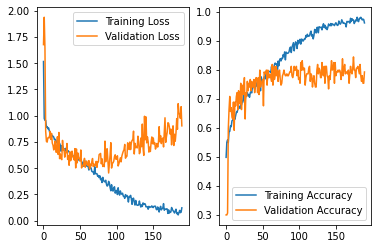

In [21]:
## Loss and accuracy history
_, axs = plt.subplots(ncols=2)
df_history_info = pd.DataFrame(history_info) 


sns.lineplot(data=df_history_info['loss'],ax=axs[0], label='Training Loss', legend='brief')
sns.lineplot(data=df_history_info['val_loss'],ax=axs[0], label='Validation Loss', legend='brief')

sns.lineplot(data=df_history_info['acc'],ax=axs[1], label='Training Accuracy', legend='brief')
sns.lineplot(data=df_history_info['val_acc'],ax=axs[1], label='Validation Accuracy', legend='brief')

In [22]:
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted

[[103  15  16]
 [ 13 107  15]
 [ 25  10  80]]


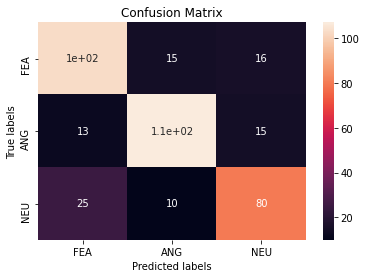

In [23]:
Y_pred = model.predict(X_test)
actual, predicted = generate_actual_predicted(Y_pred, X_test, Y_test)

##Confusion Matrix
from sklearn.metrics import confusion_matrix
actual_labeled = list()
predict_labeled = list()
for x,y in zip(actual,predicted):
    actual_labeled.append(getEmotion(x))
    predict_labeled.append(getEmotion(y))

labels = ['FEA','ANG','NEU']
cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

In [24]:
## Test accuracy
from sklearn.metrics import accuracy_score
print('accuracy', accuracy_score(actual, predicted))


accuracy 0.7552083333333334


In [25]:
## Precision, Recall, F1, Support
from sklearn.metrics import classification_report
print(classification_report(actual_labeled, predict_labeled,labels=labels))

              precision    recall  f1-score   support

         FEA       0.73      0.77      0.75       134
         ANG       0.81      0.79      0.80       135
         NEU       0.72      0.70      0.71       115

    accuracy                           0.76       384
   macro avg       0.75      0.75      0.75       384
weighted avg       0.76      0.76      0.76       384



In [16]:
##ROC AUC Scores
#from sklearn.metrics import roc_auc_score
#print('One-vs-One ROC AUC scores:')
#print(roc_auc_score(actual, Y_pred, average='macro', multi_class='ovo'), '(macro)')
#print(roc_auc_score(actual, Y_pred, average='weighted', multi_class='ovo'), '(weighted by prevalence)')


#print()
#print('One-vs-Rest ROC AUC scores:')
#print(roc_auc_score(actual, Y_pred, average='macro', multi_class='ovr'), '(macro)')
#print(roc_auc_score(actual, Y_pred, average='weighted', multi_class='ovr'), '(weighted by prevalence)')

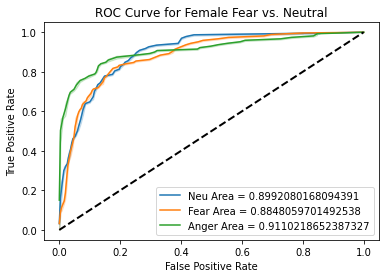

In [26]:
## ROC Curves
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from scipy import interp

### The following curves are generated s.t each point is a model from differing thresholds

_, axs = plt.subplots(ncols=1)
axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve for Female Fear vs. Neutral')


fpr, tpr, _ = roc_curve(Y_test[:,0], Y_pred[:,0])
auc_val = auc(fpr, tpr)
sns.lineplot(x=fpr,y=tpr,ax=axs, label='Neu Area = ' + str(auc_val) + '', legend='brief')

fpr, tpr, _ = roc_curve(Y_test[:,1], Y_pred[:,1])
auc_val = auc(fpr, tpr)
sns.lineplot(x=fpr,y=tpr,ax=axs, label='Fear Area = ' + str(auc_val) + '', legend='brief')

fpr, tpr, _ = roc_curve(Y_test[:,2], Y_pred[:,2])
auc_val = auc(fpr, tpr)
sns.lineplot(x=fpr,y=tpr,ax=axs, label='Anger Area = ' + str(auc_val) + '', legend='brief')

plt.plot([0, 1], [0, 1], 'k--', lw=2)

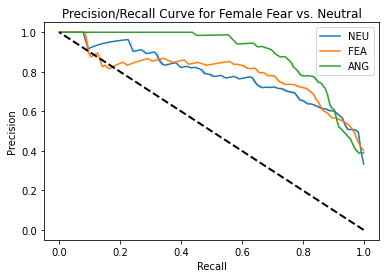

In [27]:
## Precision/Recall Curves per class
### The following curves are generated s.t each point is a model from differing thresholds
from sklearn.metrics import precision_recall_curve

_, axs = plt.subplots(ncols=1)
axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve for Female Fear vs. Neutral')

prec, rec, _ = precision_recall_curve(Y_test[:,0], Y_pred[:,0])
sns.lineplot(x=rec,y=prec,ax=axs, label = 'NEU')

prec, rec, _ = precision_recall_curve(Y_test[:,1], Y_pred[:,1])
sns.lineplot(x=rec,y=prec,ax=axs, label = 'FEA')

prec, rec, _ = precision_recall_curve(Y_test[:,2], Y_pred[:,2])
sns.lineplot(x=rec,y=prec,ax=axs, label = 'ANG')

# Diagonal line for comparison
plt.plot([1, 0], [0, 1], 'k--', lw=2)

<h2>K-Fold Training and Evaluation</h2>

In [ ]:
#Precision Mean and Standard Deviation
#Recall Mean and Standard Deviation
#F1 Measure Mean and Standard Deviation
#True Positive Rate. Mean and Standard Deviation
#False Negative Rate Mean and Standard Deviation
#Best/Worst ROC
#Best/Worst Precision/Recall
#Accuracy Mean and Standard Deviation

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve

all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()


all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()

all_accuracy = list()


n_split=3
for train_index,test_index in KFold(n_split).split(X_all):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]

    # create and fit the model
    cv_model=build_current_model()
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=30,
              validation_split=0.1,
              verbose=1)
    
    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')

    
    curr_fpr = [0] * 6
    curr_tpr = [0] * 6
    for i in range(6):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * 6
    curr_rec = [0] * 6
    for i in range(6):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    
    


In [ ]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



In [ ]:
# Plot all K-Fold ROC curves
for i in range(3):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(6):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getEmotion(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        

In [ ]:
#Plot all K-Fold Precision/Recall curves
for i in range(3):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(6):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getEmotion(j), legend='brief')

<h2>Storing/Loading history and model to file</h2>

In [ ]:
#Store History
hist_df = pd.DataFrame(history.history) 
hist_json_file = 'ref7varhistory.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [ ]:
#Load History 
history_info = pd.read_json('history.json')

In [ ]:
##Save Model
model.save('ref7var_trained.model') #Save the model

In [ ]:
## Load Model
model = tf.keras.models.load_model('mobile_net_trained.model') #Re load model